In [3]:
%pip install psx-data-reader
%pip install statistics
from psx import stocks, tickers
import datetime
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time 
from scipy.stats import norm

#importing data for silk bank
tickers = tickers()
data = stocks("SILK", start=datetime.date(2023, 2, 1), end=datetime.date.today())

# Transforming data
df_data= data
df_data.head()

# Calculate daily return  
df_data['daily return'] = np.log(df_data['Close']) - np.log(df_data['Close'].shift(1))
df_data['volatility'] = np.sqrt(((df_data['Close'] - df_data['daily return'])/296))

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
df_data.tail()

,Open,High,Low,Close,Volume,daily return,volatility
Date,,,,,,,
2024-02-13,1.06,1.06,1.01,1.03,2182000.0,0.009756,0.058709
2024-02-14,1.04,1.06,1.03,1.06,2051000.0,0.028710,0.059026
2024-02-15,1.04,1.07,1.04,1.04,1545500.0,-0.019048,0.059815
2024-02-16,1.05,1.06,1.00,1.03,7657000.0,-0.009662,0.059265
2024-02-19,1.03,1.05,1.01,1.04,2489500.0,0.009662,0.058999


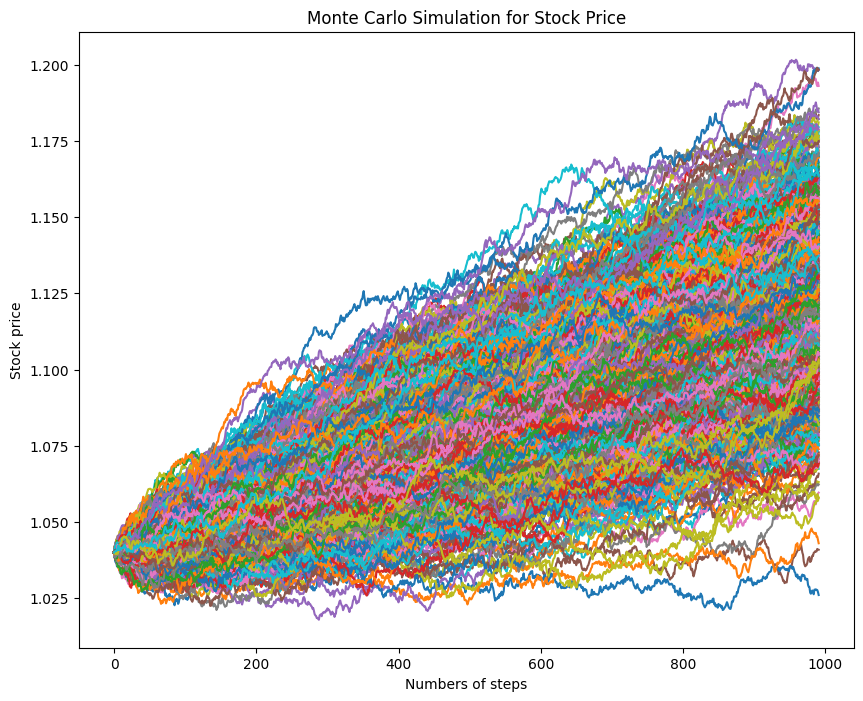

Monte Carlo price: 8.235666318274706


In [6]:
# Monte carlo simulation
def mc_asset(S0, r, sigma, T, Nsteps, Nrep):
    SPATH = np.zeros((Nrep, 1 + Nsteps))
    SPATH[:, 0] = S0
    dt = T / Nsteps
    nudt = (r - 0.5 * sigma **2) * dt
    sidt = sigma * np.sqrt(dt)
    
    for i in range(0,Nrep):
        for j in range(0,Nsteps):
            SPATH[i,j+1] = SPATH[i,j] * np.exp(nudt + sidt * np.random.normal())
    return SPATH

S0 = 1.04
K = 10
CallOrPut = 'put'
r = 0.15
sigma = 0.032244
T = 0.5
Nsteps = 991
Nrep = 1000
Npilot=5000
SPATH = mc_asset(S0, r, sigma, T, Nsteps, Nrep)

plt.figure(figsize = (10,8))
for i in range(len(SPATH)):
    plt.plot(SPATH[i])
plt.xlabel('Numbers of steps')
plt.ylabel('Stock price')
plt.title('Monte Carlo Simulation for Stock Price')
plt.show()

def mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep):
    SPATH = mc_asset(S0, r, sigma, T, Nsteps, Nrep)
    if CallOrPut == 'call':
        payoffs = np.maximum(SPATH[:,-1] - K, 0)
        return np.mean(payoffs) * np.exp(-r*T)
    else:
        payoffs = np.maximum(K - SPATH[:,-1], 0)
        return np.mean(payoffs)*np.exp(-r*T)
        
p_ = mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep)
print(f'Monte Carlo price: {p_}')

In [7]:
#Black Scholes Method
class BS_formula:

    def __init__(self, s0, k, r, sigma, T):     
        self.s0 = s0 # underlying asset price
        self.k = k # stike price
        self.r = r # risk-free rate
        self.sigma = sigma # historical return volatility
        self.T = T # time to maturity
        self.d1 = (np.log(s0/k)+(r+sigma**2/2)*T) / (sigma * np.sqrt(T))
        self.d2 = ((np.log(s0/k)+(r+sigma**2/2)*T) / (sigma * np.sqrt(T))) - sigma*np.sqrt(T)
        
    def BS_price(self): # calc theoretical price
        c = self.s0*norm.cdf(self.d1) - self.k*np.exp(-self.r*self.T)*norm.cdf(self.d2)
        p = self.k*np.exp(-self.r*self.T)*norm.cdf(-self.d2) - self.s0*norm.cdf(-self.d1)
        return c,p
        
    def BS_delta(self): # calc delta
        return norm.cdf(self.d1), norm.cdf(self.d1)-1
    
    def BS_gamma(self): # calc gamma
        return norm.pdf(self.d1)/(self.s0*self.sigma*np.sqrt(self.T)), norm.pdf(self.d1)/(self.s0*self.sigma*np.sqrt(self.T))
    
    def BS_vega(self): # calc vega
        return self.s0*np.sqrt(self.T)*norm.pdf(self.d1), self.s0*np.sqrt(self.T)*norm.pdf(self.d1)
    
    def BS_theta(self): # calc theta 
        c_theta = -self.s0*norm.pdf(self.d1)*self.sigma / (2*np.sqrt(self.T)) - self.r*self.k*np.exp(-self.r*self.T)*norm.cdf(self.d2)
        p_theta = -self.s0*norm.pdf(self.d1)*self.sigma / (2*np.sqrt(self.T)) + self.r*self.k*np.exp(-self.r*self.T)*norm.cdf(-self.d2)
        return c_theta, p_theta
    
    def BS_rho(self): # calc rho  
        return self.k*self.T*np.exp(-self.r*self.T)*norm.cdf(self.d2), -self.k*self.T*np.exp(-self.r*self.T)*norm.cdf(-self.d2)

In [8]:
p_ = mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep)
mybs = BS_formula(S0, K, r, sigma, T)
c, p = mybs.BS_price()

print(f'Black Scholes price: {p}')

Black Scholes price: 8.237434863285529


In [9]:
# Antithetic Variate Method
def mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep):

    SPATH1 = np.zeros((int(Nrep/2), 1 + Nsteps))
    SPATH2 = np.zeros((int(Nrep/2), 1 + Nsteps))
    SPATH1[:, 0], SPATH2[:, 0] = S0, S0
    dt = T / Nsteps
    nudt = (r - 0.5 * sigma **2) * dt
    sidt = sigma * np.sqrt(dt)
    
    for i in range(0,int(Nrep/2)):
        for j in range(0,Nsteps):
            epsilon = np.random.normal()
            SPATH1[i,j+1] = SPATH1[i,j] * np.exp(nudt + sidt * epsilon)
            SPATH2[i,j+1] = SPATH2[i,j] * np.exp(nudt - sidt * epsilon)
            
    if CallOrPut == 'call':
        C1 = np.maximum(SPATH1[:, -1] - K, 0)
        C2 = np.maximum(SPATH2[:, -1] - K, 0)
        C = np.mean(0.5 * (C1 + C2))
        C0 = np.exp(-r*T) * C
        return C0
    else: 
        P1 = np.maximum(K - SPATH1[:, -1], 0)
        P2 = np.maximum(K - SPATH2[:, -1], 0)
        P = np.mean(0.5 * (P1 + P2))
        P0 = np.exp(-r*T) * P
        return P0

In [10]:
print('Price under AV: ', mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Price under MC: ', mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))

Price under AV:  8.237457409997997
Price under MC:  8.237218035574365


In [11]:
#Control Variate Method
def mc_options_CV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep, Npilot):
    
    # Calculate covariance between stock and options price
    SPATH = np.zeros((Npilot, 1 + Nsteps))
    SPATH[:, 0] = S0
    dt = T / Nsteps
    nudt = (r - 0.5 * sigma **2) * dt
    sidt = sigma * np.sqrt(dt)
    
    for i in range(0,Npilot):
        for j in range(0,Nsteps):
            SPATH[i,j+1] = SPATH[i,j] * np.exp(nudt + sidt * np.random.normal())
    Sn = SPATH[:, -1] 
    if CallOrPut == 'call':
        Cn = np.maximum(SPATH[:,-1] - K, 0) * np.exp(-r*T)
        MatCov = np.cov(Sn, Cn)[0,1]
        VarY = S0 ** 2 * np.exp(2 * r * T) * (np.exp(T * sigma ** 2) - 1)
        c = -MatCov / VarY
        ExpY = S0 * np.exp(r*T)
    else:
        Pn = np.maximum(K - SPATH[:,-1], 0) * np.exp(-r*T)
        MatCov = np.cov(Sn, Pn)[0,1]
        VarY = S0 ** 2 * np.exp(2 * r * T) * (np.exp(T * sigma ** 2) - 1)
        c = -MatCov / VarY
        ExpY = S0 * np.exp(r*T)

    
    # Applying control variate function with optimal c*
    SPATH2 = np.zeros((Nrep, 1 + Nsteps))
    SPATH2[:, 0] =S0
    dt = T / Nsteps
    nudt = (r - 0.5 * sigma **2) * dt
    sidt = sigma * np.sqrt(dt)
    
    for i in range(0,Nrep):
        for j in range(0,Nsteps):
            SPATH2[i,j+1] = SPATH2[i,j] * np.exp(nudt + sidt * np.random.normal())
    S = SPATH2[:, -1] 
    if CallOrPut == 'call':
        C = np.maximum(SPATH2[:,-1] - K, 0) * np.exp(-r*T)
        CVC = np.mean(C + c * (S - ExpY))
        return CVC
    else:
        P = np.maximum(K - SPATH2[:,-1], 0) * np.exp(-r*T)
        CVP = np.mean(P + c * (S - ExpY))
        return CVP

In [12]:
print('Price under AV: ', mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Price under CV: ', mc_options_CV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep, Npilot))
print('Price under MC: ', mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print(f'Black Scholes price: {p}')

Price under AV:  8.237430157121041
Price under CV:  8.237428692366198
Price under MC:  8.237506119203491
Black Scholes price: 8.237434863285529
